# **CS224W - Colab 2**

In Colab 2, we will work to construct our own graph neural network using PyTorch Geometric (PyG) and then apply that model on two Open Graph Benchmark (OGB) datasets. These two datasets will be used to benchmark your model's performance on two different graph-based tasks: 1) node property prediction, predicting properties of single nodes and 2) graph property prediction, predicting properties of entire graphs or subgraphs.

First, we will learn how PyTorch Geometric stores graphs as PyTorch tensors.

Then, we will load and inspect one of the Open Graph Benchmark (OGB) datasets by using the `ogb` package. OGB is a collection of realistic, large-scale, and diverse benchmark datasets for machine learning on graphs. The `ogb` package not only provides data loaders for each dataset but also model evaluators.

Lastly, we will build our own graph neural network using PyTorch Geometric. We will then train and evaluate our model on the OGB node property prediction and graph property prediction tasks.

# Device

In [1]:
import torch

print("PyTorch has version {}".format(torch.__version__))
print("==============================")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

device = 3

print('Device: {}'.format(device))

PyTorch has version 1.10.2
GPU 0: NVIDIA RTX A6000
GPU 1: NVIDIA RTX A6000
GPU 2: NVIDIA RTX A6000
GPU 3: NVIDIA RTX A6000
Device: 3


In [2]:
!nvidia-smi

Tue Feb 22 22:58:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:01:00.0 Off |                  Off |
| 30%   42C    P8    15W / 300W |      8MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    On   | 00000000:2E:00.0 Off |                  Off |
| 30%   

# 1) PyTorch Geometric (Datasets and Data)


PyTorch Geometric has two classes for storing and/or transforming graphs into tensor format. One is `torch_geometric.datasets`, which contains a variety of common graph datasets. Another is `torch_geometric.data`, which provides the data handling of graphs in PyTorch tensors.

In this section, we will learn how to use `torch_geometric.datasets` and `torch_geometric.data` together.

## PyG Datasets

The `torch_geometric.datasets` class has many common graph datasets. Here we will explore its usage through one example dataset.

In [3]:
from torch_geometric.datasets import TUDataset


root = './dataset/enzymes'
name = 'ENZYMES'

# The ENZYMES dataset
pyg_dataset= TUDataset(root, name)

# You will find that there are 600 graphs in this dataset
print(f"The {pyg_dataset} dataset has {len(pyg_dataset)} graphs")

The ENZYMES(600) dataset has 600 graphs


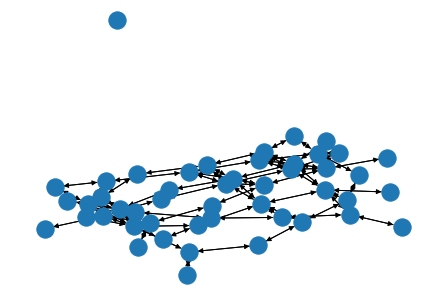

In [4]:
import networkx as nx
from torch_geometric.utils import to_networkx

nx.draw(to_networkx(pyg_dataset[599]))

## Question 1: What is the number of classes and number of features in the ENZYMES dataset? (5 points)

In [5]:
def get_num_classes(pyg_dataset):
    return pyg_dataset.num_classes

def get_num_features(pyg_dataset):
    return pyg_dataset.num_features


num_classes = get_num_classes(pyg_dataset)
num_features = get_num_features(pyg_dataset)
print("{} dataset has {} classes".format(name, num_classes))
print("{} dataset has {} features".format(name, num_features))

ENZYMES dataset has 6 classes
ENZYMES dataset has 3 features


## PyG Data

Each PyG dataset stores a list of `torch_geometric.data.Data` objects, where each `torch_geometric.data.Data` object represents a graph. We can easily get the `Data` object by indexing into the dataset.

For more information such as what is stored in the `Data` object, please refer to the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data).

## Question 2: What is the label of the graph with index 100 in the ENZYMES dataset? (5 points)

In [6]:
pyg_dataset.data

Data(x=[19580, 3], edge_index=[2, 74564], y=[600])

In [7]:
def get_graph_class(pyg_dataset, idx):
    # a function that takes a PyG dataset object,
    # an index of a graph within the dataset, and returns the class/label 
    # of the graph (as an integer).
    return pyg_dataset[idx].y


# Here pyg_dataset is a dataset for graph classification
idx = 100
label = get_graph_class(pyg_dataset, idx)
print(pyg_dataset[idx])
print('Graph with index {} has label {}'.format(idx, label))

Data(edge_index=[2, 176], x=[45, 3], y=[1])
Graph with index 100 has label tensor([4])


## Question 3: How many edges does the graph with index 200 have? (5 points)

In [8]:
def get_graph_num_edges(pyg_dataset, idx):
    # a function that takes a PyG dataset object,
    # the index of a graph in the dataset, and returns the number of 
    # edges in the graph (as an integer). You should not count an edge 
    # twice if the graph is undirected. For example, in an undirected 
    # graph G, if two nodes v and u are connected by an edge, this edge
    # should only be counted once.
    
    ## Note:
    ## 1. You can't return the data.num_edges directly
    ## 2. We assume the graph is undirected
    ## 3. Look at the PyG dataset built in functions

    return pyg_dataset[idx].num_edges // 2


idx = 200
num_edges = get_graph_num_edges(pyg_dataset, idx)
print('Graph with index {} has {} edges'.format(idx, num_edges))

Graph with index 200 has 53 edges


# 2) Open Graph Benchmark (OGB)

The Open Graph Benchmark (OGB) is a collection of realistic, large-scale, and diverse benchmark datasets for machine learning on graphs. Its datasets are automatically downloaded, processed, and split using the OGB Data Loader. The model performance can then be evaluated by using the OGB Evaluator in a unified manner.

## Dataset and Data

OGB also supports PyG dataset and data classes. Here we take a look on the `ogbn-arxiv` dataset.

In [9]:
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset

dataset_name = 'ogbn-arxiv'
# Load the dataset and transform it to sparse tensor
dataset = PygNodePropPredDataset(name=dataset_name,
                              transform=T.ToSparseTensor())
print('The {} dataset has {} graph'.format(dataset_name, len(dataset)))

# Extract the graph
data = dataset[0]
print(data)

The ogbn-arxiv dataset has 1 graph
Data(x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343, nnz=1166243])


## Question 4: How many features are in the ogbn-arxiv graph? (5 points)

In [10]:
def graph_num_features(data):
    # TODO: Implement a function that takes a PyG data object,
    # and returns the number of features in the graph (as an integer).
    return data.num_features


num_features = graph_num_features(data)
print('The graph has {} features'.format(num_features))

The graph has 128 features


# 3) GNN: Node Property Prediction

In this section we will build our first graph neural network using PyTorch Geometric. Then we will apply it to the task of node property prediction (node classification).

Specifically, we will use GCN as the foundation for your graph neural network ([Kipf et al. (2017)](https://arxiv.org/pdf/1609.02907.pdf)). To do so, we will work with PyG's built-in `GCNConv` layer. 

## Setup

In [11]:
import torch
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F

# The PyG built-in GCNConv
from torch_geometric.nn import GCNConv

import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

## Load and Preprocess the Dataset

In [12]:
dataset_name = 'ogbn-arxiv'
dataset = PygNodePropPredDataset(name=dataset_name,
                                 transform=T.ToSparseTensor())
data = dataset[0]

# Make the adjacency matrix to symmetric
data.adj_t = data.adj_t.to_symmetric()

data = data.to(device)
split_idx = dataset.get_idx_split()
train_idx = split_idx['train'].to(device)

## GCN Model

Now we will implement our GCN model!

Please follow the figure below to implement the `forward` function.


![test](https://drive.google.com/uc?id=128AuYAXNXGg7PIhJJ7e420DoPWKb-RtL)


In [13]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, return_embeds=False):
        # initializes self.convs, self.bns, and self.softmax.

        super(GCN, self).__init__()

        # A list of GCNConv layers
        self.convs = nn.ModuleList(
            [GCNConv(input_dim, hidden_dim)] + 
            [GCNConv(hidden_dim, hidden_dim) for _ in range(num_layers - 1)] +
            [GCNConv(hidden_dim, output_dim)]
        )

        # A list of 1D batch normalization layers
        self.bns = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(num_layers - 1)])

        # Probability of an element getting zeroed
        self.dropout = nn.Dropout(p=dropout)

        # Skip classification layer and return node embeddings
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        
        for conv, bn in zip(self.convs[:-1], self.bns):
            x = self.dropout(bn(conv(x, adj_t)).relu())
        out = self.convs[-1](x, adj_t)
        if not self.return_embeds:
            out = out.log_softmax(dim=-1)

        return out

In [14]:
def train(model, data, train_idx, optimizer, loss_fn):
    model.train()
    loss = 0

    ## Note:
    ## 1. Zero grad the optimizer
    ## 2. Feed the data into the model
    ## 3. Slice the model output and label by train_idx
    ## 4. Feed the sliced output and label to loss_fn
    optimizer.zero_grad()
    out = model(data.x, data.adj_t)
    loss = loss_fn(out[train_idx], data.y[train_idx].squeeze(1))
    
    loss.backward()
    optimizer.step()

    return loss.item()

In [15]:
# Test function here
@torch.no_grad()
def test(model, data, split_idx, evaluator, save_model_results=False):
    model.eval()

    # The output of model on all data
    # No index slicing here
    out = model(data.x, data.adj_t)

    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    if save_model_results:
        print ("Saving Model Predictions")

        data = {}
        data['y_pred'] = y_pred.view(-1).cpu().detach().numpy()

        df = pd.DataFrame(data=data)
        # Save locally as csv
        df.to_csv('ogbn-arxiv_node.csv', sep=',', index=False)


    return train_acc, valid_acc, test_acc

In [16]:
# Please do not change the args
args = {
  'device': device,
  'num_layers': 3,
  'hidden_dim': 256,
  'dropout': 0.5,
  'lr': 0.01,
  'epochs': 100,
}
args

{'device': 3,
 'num_layers': 3,
 'hidden_dim': 256,
 'dropout': 0.5,
 'lr': 0.01,
 'epochs': 100}

In [17]:
model = GCN(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)
evaluator = Evaluator(name='ogbn-arxiv')

In [18]:
import copy
# reset the parameters to initial random value
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):
    loss = train(model, data, train_idx, optimizer, loss_fn)
    result = test(model, data, split_idx, evaluator)
    train_acc, valid_acc, test_acc = result
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 4.0635, Train: 24.54%, Valid: 28.63% Test: 25.63%
Epoch: 02, Loss: 2.2768, Train: 25.42%, Valid: 23.24% Test: 28.48%
Epoch: 03, Loss: 1.9387, Train: 30.86%, Valid: 26.25% Test: 31.10%
Epoch: 04, Loss: 1.7615, Train: 36.97%, Valid: 33.74% Test: 32.65%
Epoch: 05, Loss: 1.6469, Train: 41.34%, Valid: 36.54% Test: 33.51%
Epoch: 06, Loss: 1.5577, Train: 42.20%, Valid: 36.61% Test: 36.09%
Epoch: 07, Loss: 1.4848, Train: 42.98%, Valid: 36.76% Test: 39.35%
Epoch: 08, Loss: 1.4284, Train: 44.65%, Valid: 39.92% Test: 43.40%
Epoch: 09, Loss: 1.3901, Train: 45.29%, Valid: 39.87% Test: 42.01%
Epoch: 10, Loss: 1.3620, Train: 46.34%, Valid: 42.51% Test: 44.99%
Epoch: 11, Loss: 1.3276, Train: 47.92%, Valid: 45.41% Test: 48.36%
Epoch: 12, Loss: 1.2985, Train: 47.61%, Valid: 43.96% Test: 47.10%
Epoch: 13, Loss: 1.2770, Train: 47.11%, Valid: 42.53% Test: 45.40%
Epoch: 14, Loss: 1.2619, Train: 48.14%, Valid: 44.15% Test: 45.99%
Epoch: 15, Loss: 1.2419, Train: 50.32%, Valid: 47.93% Test: 49

## Question 5: What are your `best_model` validation and test accuracies?(20 points)

Run the cell below to see the results of your best of model and save your model's predictions to a file named *ogbn-arxiv_node.csv*. 

You can view this file by clicking on the *Folder* icon on the left side pannel. As in Colab 1, when you sumbit your assignment, you will have to download this file and attatch it to your submission.

In [19]:
best_result = test(best_model, data, split_idx, evaluator, save_model_results=True)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
     f'Train: {100 * train_acc:.2f}%, '
     f'Valid: {100 * valid_acc:.2f}% '
     f'Test: {100 * test_acc:.2f}%')

Saving Model Predictions
Best model: Train: 73.63%, Valid: 72.12% Test: 71.49%


# 4) GNN: Graph Property Prediction

In this section we will create a graph neural network for graph property prediction (graph classification).


## Load and preprocess the dataset

In [20]:
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from torch_geometric.loader import DataLoader
from tqdm.std import tqdm
import sys


# Load the dataset 
dataset = PygGraphPropPredDataset(name='ogbg-molhiv')

print('Device: {}'.format(device))

split_idx = dataset.get_idx_split()

# Check task type
print('Task type: {}'.format(dataset.task_type))

Device: 3
Task type: binary classification


In [21]:
# Load the dataset splits into corresponding dataloaders
# We will train the graph classification task on a batch of 32 graphs
# Shuffle the order of graphs for training set
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False, num_workers=0)

In [22]:
args = {
    'device': device,
    'num_layers': 5,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.001,
    'epochs': 30,
}
args

{'device': 3,
 'num_layers': 5,
 'hidden_dim': 256,
 'dropout': 0.5,
 'lr': 0.001,
 'epochs': 30}

## Graph Prediction Model

### Graph Mini-Batching
Before diving into the actual model, we introduce the concept of mini-batching with graphs. In order to parallelize the processing of a mini-batch of graphs, PyG combines the graphs into a single disconnected graph data object (*torch_geometric.data.Batch*). *torch_geometric.data.Batch* inherits from *torch_geometric.data.Data* (introduced earlier) and contains an additional attribute called `batch`. 

The `batch` attribute is a vector mapping each node to the index of its corresponding graph within the mini-batch:

    batch = [0, ..., 0, 1, ..., n - 2, n - 1, ..., n - 1]

This attribute is crucial for associating which graph each node belongs to and can be used to e.g. average the node embeddings for each graph individually to compute graph level embeddings. 



### Implemention
Now, we have all of the tools to implement a GCN Graph Prediction model!  

We will reuse the existing GCN model to generate `node_embeddings` and then use  `Global Pooling` over the nodes to create graph level embeddings that can be used to predict properties for the each graph. Remeber that the `batch` attribute will be essential for performining Global Pooling over our mini-batch of graphs.

In [23]:
from ogb.graphproppred.mol_encoder import AtomEncoder
from torch_geometric.nn import global_add_pool, global_mean_pool, global_sort_pool, global_max_pool

### GCN to predict graph property
class GCN_Graph(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers, dropout, pooling_fn=global_mean_pool):
        super(GCN_Graph, self).__init__()

        # Load encoders for Atoms in molecule graphs
        self.node_encoder = AtomEncoder(hidden_dim)

        # Node embedding model
        # Note that the input_dim and output_dim are set to hidden_dim
        self.gnn_node = GCN(hidden_dim, hidden_dim,
            hidden_dim, num_layers, dropout, return_embeds=True)

        ## Note:
        ## Initialize self.pool as a global mean pooling layer
        ## For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
        self.pool = pooling_fn
        
        # Output layer
        self.linear = torch.nn.Linear(hidden_dim, output_dim)


    def reset_parameters(self):
        self.gnn_node.reset_parameters()
        self.linear.reset_parameters()

    def forward(self, batched_data):
        # a function that takes as input a 
        # mini-batch of graphs (torch_geometric.data.Batch) and 
        # returns the predicted graph property for each graph. 
        #
        # NOTE: Since we are predicting graph level properties,
        # your output will be a tensor with dimension equaling
        # the number of graphs in the mini-batch

        # Extract important attributes of our mini-batch
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
        embed = self.node_encoder(x)

        ## Note:
        ## 1. Construct node embeddings using existing GCN model
        ## 2. Use the global pooling layer to aggregate features for each individual graph
        ## For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
        ## 3. Use a linear layer to predict each graph's property
        out = self.gnn_node(embed, edge_index)
        out = self.pool(out, batch)
        out = self.linear(out)

        return out

In [24]:
def train(model, device, data_loader, optimizer, loss_fn):
    
    model.train()
    total_loss = 0.
    total_len = 0

    iterator = tqdm(data_loader, desc="[Train] Iteration", leave=False, file=sys.stdout)
    for step, batch in enumerate(iterator):

        if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
            continue
        
        batch = batch.to(device)
        optimizer.zero_grad()

        ## ignore nan targets (unlabeled) when computing training loss.
        is_labeled = batch.y == batch.y
        
        ## Use `is_labeled` mask to filter output and labels
        ## You may need to change the type of label to torch.float32
        loss = loss_fn(model(batch)[is_labeled], batch.y[is_labeled].float())
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_len += is_labeled.int().sum()
        
        if step % 10 == 0:
            iterator.set_postfix(loss=loss.item())

    return total_loss / total_len if total_len else float('nan')

In [25]:
# The evaluation function
def evaluate(model, device, loader, evaluator, save_model_results=False, save_file=None):
    model.eval()
    y_true = []
    y_pred = []

    iterator = tqdm(loader, desc="[Valid] Iteration", leave=False, file=sys.stdout)
    for step, batch in enumerate(iterator):
        batch = batch.to(device)

        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch)

            y_true.append(batch.y.view(pred.shape).detach().cpu())
            y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim = 0).numpy()
    y_pred = torch.cat(y_pred, dim = 0).numpy()

    input_dict = {"y_true": y_true, "y_pred": y_pred}

    if save_model_results:
        print("Saving Model Predictions")
        
        # Create a pandas dataframe with a two columns
        # y_pred | y_true
        data = {}
        data['y_pred'] = y_pred.reshape(-1)
        data['y_true'] = y_true.reshape(-1)

        df = pd.DataFrame(data=data)
        # Save to csv
        df.to_csv('ogbg-molhiv_graph_' + save_file + '.csv', sep=',', index=False)

    return evaluator.eval(input_dict)

In [26]:
model = GCN_Graph(args['hidden_dim'],
                  dataset.num_tasks, args['num_layers'],
                  args['dropout']).to(device)
evaluator = Evaluator(name='ogbg-molhiv')

In [27]:
import copy

model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.BCEWithLogitsLoss()

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):
    # Train
    loss = train(model, device, train_loader, optimizer, loss_fn)
    # Eval
    train_result = evaluate(model, device, train_loader, evaluator)
    val_result = evaluate(model, device, valid_loader, evaluator)
    test_result = evaluate(model, device, test_loader, evaluator)

    train_acc, valid_acc, test_acc = train_result[dataset.eval_metric], val_result[dataset.eval_metric], test_result[dataset.eval_metric]
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 0.0049, Train: 70.44%, Valid: 72.40% Test: 70.13%                  
Epoch: 02, Loss: 0.0047, Train: 72.45%, Valid: 71.94% Test: 75.47%                  
Epoch: 03, Loss: 0.0045, Train: 76.26%, Valid: 76.39% Test: 73.81%                 
Epoch: 04, Loss: 0.0044, Train: 76.97%, Valid: 71.05% Test: 69.30%                 
Epoch: 05, Loss: 0.0044, Train: 76.74%, Valid: 73.25% Test: 71.53%                  
Epoch: 06, Loss: 0.0044, Train: 76.85%, Valid: 75.40% Test: 70.15%                  
Epoch: 07, Loss: 0.0043, Train: 78.04%, Valid: 73.94% Test: 71.71%                  
Epoch: 08, Loss: 0.0043, Train: 78.62%, Valid: 76.92% Test: 71.20%                  
Epoch: 09, Loss: 0.0043, Train: 78.65%, Valid: 75.59% Test: 73.57%                 
Epoch: 10, Loss: 0.0042, Train: 79.98%, Valid: 74.90% Test: 71.10%                  
Epoch: 11, Loss: 0.0042, Train: 79.89%, Valid: 75.38% Test: 73.32%                 
Epoch: 12, Loss: 0.0042, Train: 79.34%, Valid: 75.35% Test: 73.14%   

## Question 6: What are your `best_model` validation and test ROC-AUC scores? (20 points)

Run the cell below to see the results of your best of model and save your model's predictions over the validation and test datasets. The resulting files are named *ogbn-arxiv_graph_valid.csv* and *ogbn-arxiv_graph_test.csv*. 

Again, you can view these files by clicking on the *Folder* icon on the left side pannel. As in Colab 1, when you sumbit your assignment, you will have to download these files and attatch them to your submission.

In [28]:
train_acc = evaluate(best_model, device, train_loader, evaluator)[dataset.eval_metric]
valid_acc = evaluate(best_model, device, valid_loader, evaluator, save_model_results=True, save_file="valid")[dataset.eval_metric]
test_acc  = evaluate(best_model, device, test_loader, evaluator, save_model_results=True, save_file="test")[dataset.eval_metric]

print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Saving Model Predictions                                               
Saving Model Predictions                                             
Best model: Train: 82.67%, Valid: 79.72% Test: 74.01%


## Question 7 (Optional): Experiment with the two other global pooling layers in Pytorch Geometric.

In [29]:
def experiment(pooling_fn, train_loader=train_loader, valid_loader=valid_loader, 
               test_loader=test_loader, device=device, args=args):
    print("Experiment of pooling: {}".format(pooling_fn.__name__))
    model = GCN_Graph(args['hidden_dim'],
                      dataset.num_tasks, args['num_layers'],
                      args['dropout'], pooling_fn).to(device)
    evaluator = Evaluator(name='ogbg-molhiv')
    model.reset_parameters()

    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
    loss_fn = torch.nn.BCEWithLogitsLoss()

    best_model = None
    best_valid_acc = 0

    for epoch in range(1, 1 + args["epochs"]):
        # Train
        loss = train(model, device, train_loader, optimizer, loss_fn)
        # Eval
        train_result = evaluate(model, device, train_loader, evaluator)
        val_result = evaluate(model, device, valid_loader, evaluator)
        test_result = evaluate(model, device, test_loader, evaluator)

        train_acc, valid_acc, test_acc = train_result[dataset.eval_metric], val_result[dataset.eval_metric], test_result[dataset.eval_metric]
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_model = copy.deepcopy(model)
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * valid_acc:.2f}% '
              f'Test: {100 * test_acc:.2f}%')

    train_acc = evaluate(best_model, device, train_loader, evaluator)[dataset.eval_metric]
    valid_acc = evaluate(best_model, device, valid_loader, evaluator)[dataset.eval_metric]
    test_acc  = evaluate(best_model, device, test_loader, evaluator)[dataset.eval_metric]

    print(f'Best model: '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

### Global Add Pooling

In [30]:
experiment(global_add_pool)

Experiment of pooling: global_add_pool
Epoch: 01, Loss: 0.0092, Train: 65.81%, Valid: 70.10% Test: 60.08%                  
Epoch: 02, Loss: 0.0058, Train: 62.73%, Valid: 53.02% Test: 45.56%                  
Epoch: 03, Loss: 0.0054, Train: 70.93%, Valid: 66.15% Test: 68.94%                  
Epoch: 04, Loss: 0.0052, Train: 68.71%, Valid: 59.66% Test: 55.95%                  
Epoch: 05, Loss: 0.0050, Train: 70.34%, Valid: 55.82% Test: 52.17%                  
Epoch: 06, Loss: 0.0049, Train: 70.11%, Valid: 69.71% Test: 64.69%                 
Epoch: 07, Loss: 0.0047, Train: 73.53%, Valid: 62.95% Test: 68.00%                  
Epoch: 08, Loss: 0.0046, Train: 75.74%, Valid: 71.69% Test: 70.72%                  
Epoch: 09, Loss: 0.0044, Train: 75.50%, Valid: 67.17% Test: 65.39%                 
Epoch: 10, Loss: 0.0044, Train: 76.35%, Valid: 72.89% Test: 72.45%                 
Epoch: 11, Loss: 0.0044, Train: 77.72%, Valid: 69.58% Test: 70.78%                  
Epoch: 12, Loss: 0.0043, Trai

### Global Max Pooling

In [32]:
experiment(global_max_pool)

Experiment of pooling: global_max_pool
Epoch: 01, Loss: 0.0049, Train: 74.39%, Valid: 68.38% Test: 72.14%                  
Epoch: 02, Loss: 0.0045, Train: 73.12%, Valid: 63.70% Test: 69.69%                 
Epoch: 03, Loss: 0.0044, Train: 77.21%, Valid: 71.29% Test: 69.72%                  
Epoch: 04, Loss: 0.0044, Train: 78.01%, Valid: 73.01% Test: 70.24%                  
Epoch: 05, Loss: 0.0043, Train: 77.83%, Valid: 71.19% Test: 71.42%                 
Epoch: 06, Loss: 0.0043, Train: 78.44%, Valid: 68.22% Test: 72.67%                 
Epoch: 07, Loss: 0.0042, Train: 79.41%, Valid: 72.79% Test: 70.63%                  
Epoch: 08, Loss: 0.0042, Train: 79.13%, Valid: 74.39% Test: 70.36%                  
Epoch: 09, Loss: 0.0041, Train: 79.99%, Valid: 73.33% Test: 69.47%                  
Epoch: 10, Loss: 0.0040, Train: 81.03%, Valid: 72.21% Test: 71.32%                 
Epoch: 11, Loss: 0.0040, Train: 81.06%, Valid: 75.34% Test: 72.16%                  
Epoch: 12, Loss: 0.0040, Train